In [368]:
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [302]:
ls = []
for files in glob.glob(os.getenv("PUIDATA") + "/NYCbusiness/*.zip"):
    zf = zipfile.ZipFile(files)
    df = pd.read_csv(zf.open(files[-15:].replace('.zip','.txt')))
    if any(df.columns == 'est'):
        df = df[['zip', 'est']]
    elif any(df.columns == 'EST'):
        df = df[['ZIP', 'EST']]
        df.rename(columns={'ZIP': 'zip', 'EST': 'est'}, inplace=True)
    else:
        print 'wrong column name'
    df.rename(columns={'est': files[-12:-10]}, inplace=True)
    ls.append(df)
df_final = reduce(lambda left,right: pd.merge(left,right,on='zip', how='outer'), ls)

In [303]:
df_final.head()

,zip,94,95,99,98,97,96,14,13,12,...,08,07,10,06,05,04,03,02,01,00
0,1001.0,439.0,439.0,469.0,444.0,457.0,433.0,458.0,439.0,453.0,...,477.0,503.0,448.0,509.0,509.0,500.0,505.0,490.0,490.0,493.0
1,1002.0,450.0,467.0,558.0,490.0,500.0,487.0,560.0,572.0,572.0,...,584.0,596.0,570.0,582.0,589.0,584.0,586.0,566.0,587.0,563.0
2,1003.0,10.0,10.0,13.0,14.0,15.0,13.0,18.0,15.0,15.0,...,17.0,16.0,16.0,12.0,12.0,15.0,16.0,15.0,13.0,13.0
3,1004.0,47.0,48.0,35.0,31.0,41.0,47.0,13.0,16.0,16.0,...,18.0,20.0,21.0,30.0,31.0,43.0,21.0,23.0,37.0,48.0
4,1005.0,92.0,95.0,82.0,95.0,104.0,101.0,97.0,97.0,94.0,...,97.0,106.0,96.0,98.0,94.0,97.0,93.0,94.0,90.0,86.0


In [304]:
zip_nyc_path = os.getenv("PUIDATA") + "/nyc-zip-code-tabulation-areas-polygons.geojson"
zip_nyc = gpd.read_file(zip_nyc_path)

In [305]:
zip_nyc.rename(columns = {"postalCode" : 'zip'},inplace = True)

In [308]:
df_nyc = df_final.loc[df_final['zip'].isin(np.int64(zip_nyc['zip']))]

In [309]:
df_nyc['zip'] = df_nyc['zip'].astype(float)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [310]:
# Clean data. drop time series with more than 5 null values, and fill the rest null value with 0.
df_nyc.set_index('zip', inplace=True)
df_nyc.isnull().sum(axis=1)[df_nyc.isnull().sum(axis=1) > 0]
df_nyc = df_nyc.drop(df_nyc.isnull().sum(axis=1)[df_nyc.isnull().sum(axis=1) > 5].index)
df_nyc.fillna(0, inplace=True)

In [311]:
# Standardize time series by subtracting each row's mean and divided by each row standard, respectively.
df_nyc = df_nyc.subtract(df_nyc.mean(axis=1), axis=0)
df_nyc = df_nyc.divide(df_nyc.std(axis=1), axis=0)

In [312]:
# Check the dimension of the standardized dataframe
df_nyc.shape

(236, 21)

In [313]:
range_n_clusters = range(3,10)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=123)
    cluster_labels = km.fit_predict(df_nyc)
    silhouette_avg = silhouette_score(df_nyc, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters = 3, the average silhouette_score is :0.514389546988
For n_clusters = 4, the average silhouette_score is :0.489353539024
For n_clusters = 5, the average silhouette_score is :0.351285617663
For n_clusters = 6, the average silhouette_score is :0.243034269957
For n_clusters = 7, the average silhouette_score is :0.244360078699
For n_clusters = 8, the average silhouette_score is :0.156138139108
For n_clusters = 9, the average silhouette_score is :0.156950063235


In [210]:

# Get the result of kmeans clustering with 4 clusters
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=123)
km_labels = km.fit_predict(df_nyc)

In [211]:
km.cluster_centers_.shape

(4, 21)

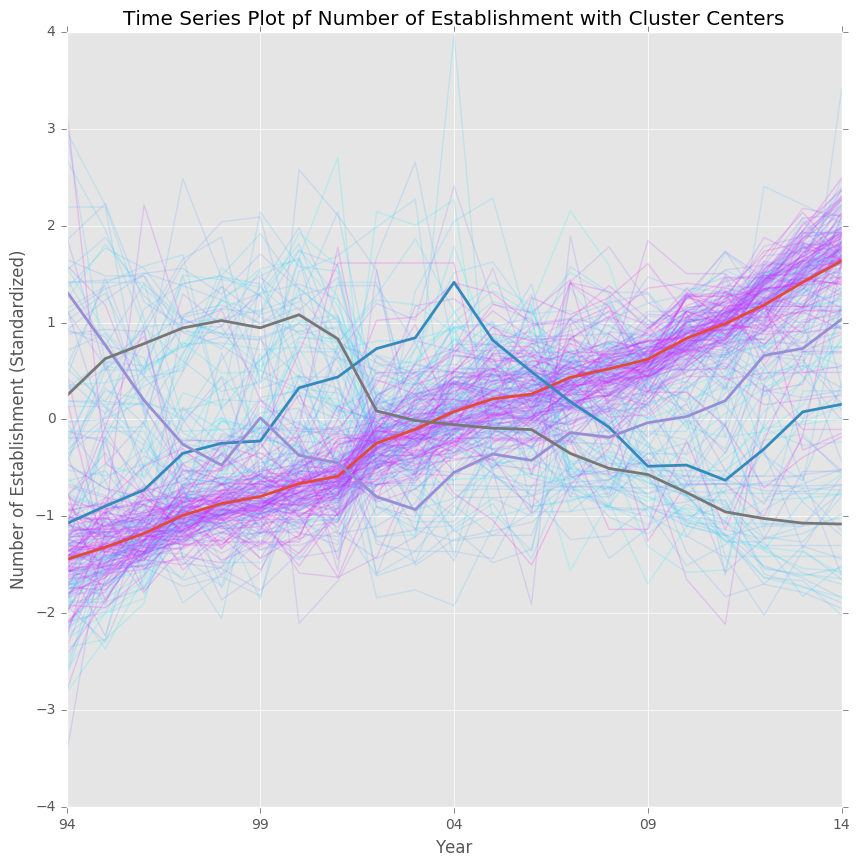

In [146]:
# Plot the KMeans clustering results with cluster center time series
ax = df_nyc.T.plot(figsize=(10,10), legend=False, c=cluster_labels, cmap=plt.cm.cool, alpha=0.2)
plt.plot(km.cluster_centers_.T, linewidth=2)
plt.xlabel('Year')
plt.ylabel('Number of Establishment (Standardized)')
plt.title('Time Series Plot pf Number of Establishment with Cluster Centers')
plt.show()

In [147]:
# Feature Agglomeration Clustering with 4 clusters
fa = FeatureAgglomeration(n_clusters=4)
fa_labels = fa.fit(df_nyc.T).labels_

In [148]:
# Combine two clustering results into the geopandas dataframe
label_nyc = pd.DataFrame({'zip': df_nyc.index, 'kmeans': cluster_labels, 'featureagglomeration': fa_labels})
label_nyc['zip'] = label_nyc['zip'].astype(int).astype('str')
cluster_nyc = pd.merge(label_nyc, zip_nyc, left_on='zip', right_on='postalCode', how='outer')
cluster_nyc = gpd.GeoDataFrame(cluster_nyc)

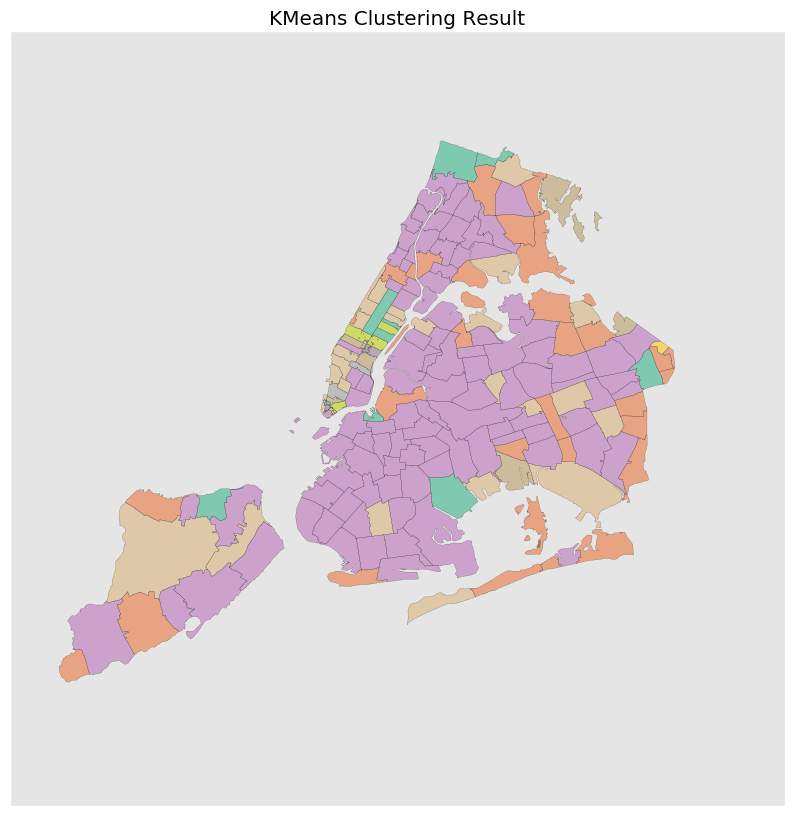

In [316]:
# Map KMeans clustering result
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
cluster_nyc.plot(column='kmeans', colormap='Set2',alpha=0.8,linewidth=0.1, ax=ax)
plt.title('KMeans Clustering Result')
plt.show()

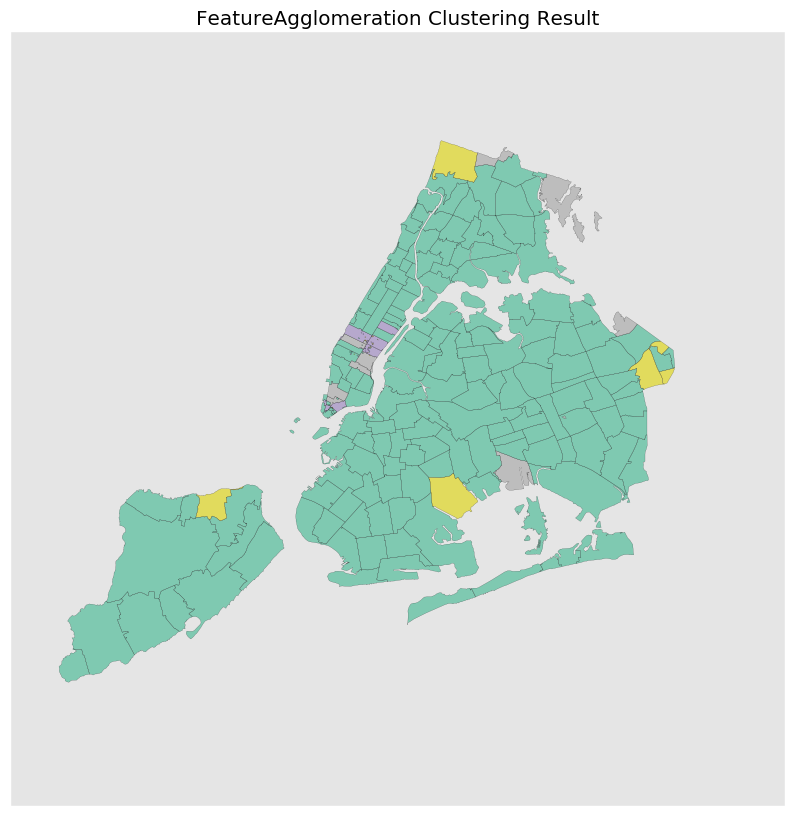

In [315]:
# Map Feature Agglomeration clustering result
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
cluster_nyc.plot(column='featureagglomeration', colormap='Set2',alpha=0.8,linewidth=0.1, ax=ax)
plt.title('FeatureAgglomeration Clustering Result')
plt.show()

In [317]:
zip_nyc.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,zip
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [318]:
nyzip = zip_nyc[['geometry','zip']]
nyzip.head()

,geometry,zip
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [319]:
type(nyzip.zip[0])

unicode

In [320]:
nyzip['zip'] = nyzip['zip'].astype(float)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [321]:
type(nyzip.zip[0])

numpy.float64

In [322]:
data_and_zip = pd.merge(nyzip, df_final, on = 'zip', how = 'inner')
data_and_zip.head(3)

,geometry,zip,94,95,99,98,97,96,14,13,...,08,07,10,06,05,04,03,02,01,00
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372.0,1229.0,1236.0,1376.0,1351.0,1309.0,1292.0,1768.0,1759.0,...,1538.0,1545.0,1629.0,1527.0,1539.0,1554.0,1521.0,1463.0,1408.0,1409.0
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004.0,194.0,188.0,186.0,194.0,192.0,176.0,250.0,241.0,...,227.0,238.0,229.0,226.0,225.0,226.0,228.0,214.0,204.0,189.0
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040.0,1422.0,1414.0,1350.0,1344.0,1344.0,1335.0,1534.0,1539.0,...,1503.0,1488.0,1494.0,1454.0,1441.0,1406.0,1403.0,1398.0,1341.0,1350.0


In [337]:
dz_mean = data_and_zip.iloc[:,range(2,22)].mean(axis=1)
dz_std = data_and_zip.iloc[:,range(2,22)].std(axis=1)
data_and_zip.iloc[:,range(2,22)] = data_and_zip.iloc[:,range(2,22)].apply(lambda x: (x- dz_mean) / dz_std)

In [338]:
data_and_zip.head()

,geometry,zip,94,95,99,98,97,96,14,13,...,08,07,10,06,05,04,03,02,01,00
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372.0,-1.647105,-1.604458,-0.751509,-0.903821,-1.159706,-1.263278,1.636748,1.581916,...,0.235475,0.278122,0.789892,0.168457,0.241567,0.332955,0.131902,-0.221462,-0.556549,1409.0
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004.0,-1.049060,-1.326345,-1.418773,-1.049060,-1.141488,-1.880914,1.538930,1.123003,...,0.476005,0.984360,0.568433,0.429791,0.383577,0.429791,0.522219,-0.124778,-0.586919,189.0
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040.0,-0.178111,-0.295386,-1.233585,-1.321541,-1.321541,-1.453475,1.463737,1.537034,...,1.009297,0.789406,0.877363,0.290988,0.100417,-0.412661,-0.456639,-0.529936,-1.365519,1350.0
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426.0,3.134190,-0.469876,-0.537242,-1.008802,-1.177216,-0.806704,0.911121,0.843756,...,-0.234096,-0.166730,0.506927,-0.234096,-0.234096,-0.402510,-0.739339,-0.874070,-0.537242,213.0
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365.0,-1.332578,-1.545046,-0.974037,-1.106829,-0.934199,-1.452091,1.841175,1.615427,...,0.314055,0.327335,0.672596,0.207821,0.154704,0.088307,-0.137441,-0.243675,-0.243675,553.0


In [356]:
data_and_zip.fillna(0, inplace=1)

In [360]:
Z = linkage(data_and_zip.iloc[:,2:22], 'complete')

In [361]:
type(Z)

numpy.ndarray

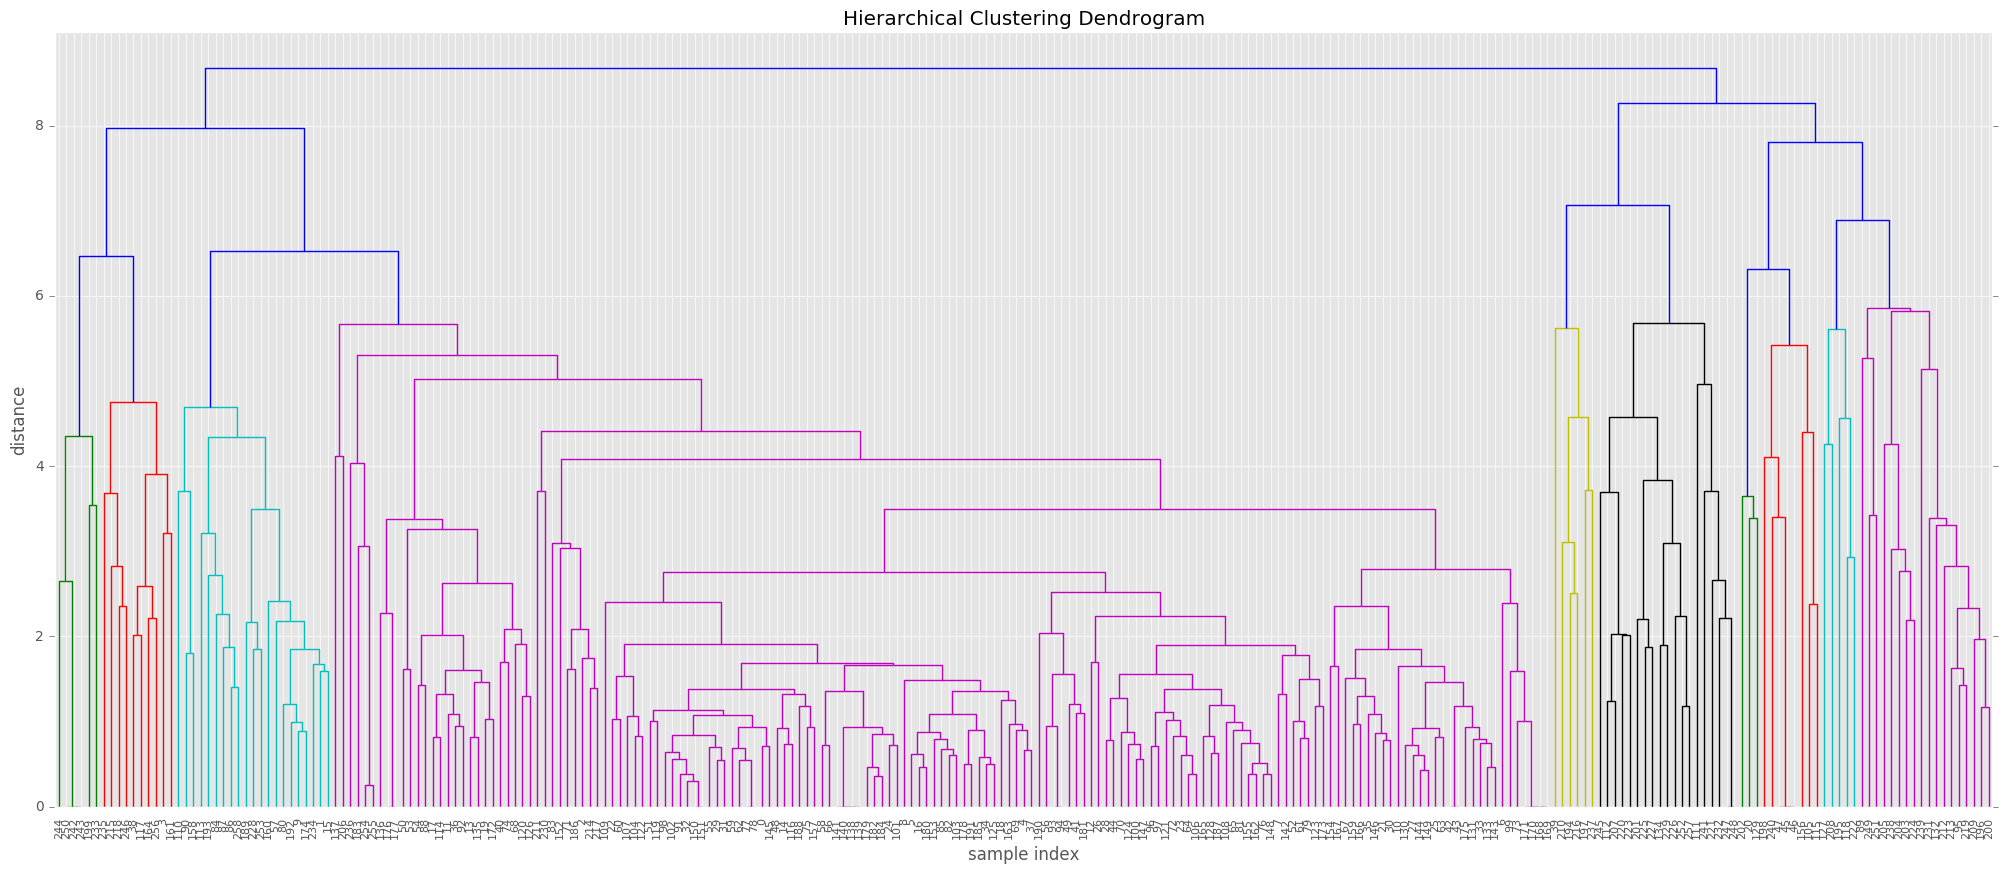

In [365]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [373]:
max_d = 6
clusters = fcluster(Z, max_d, criterion='distance')

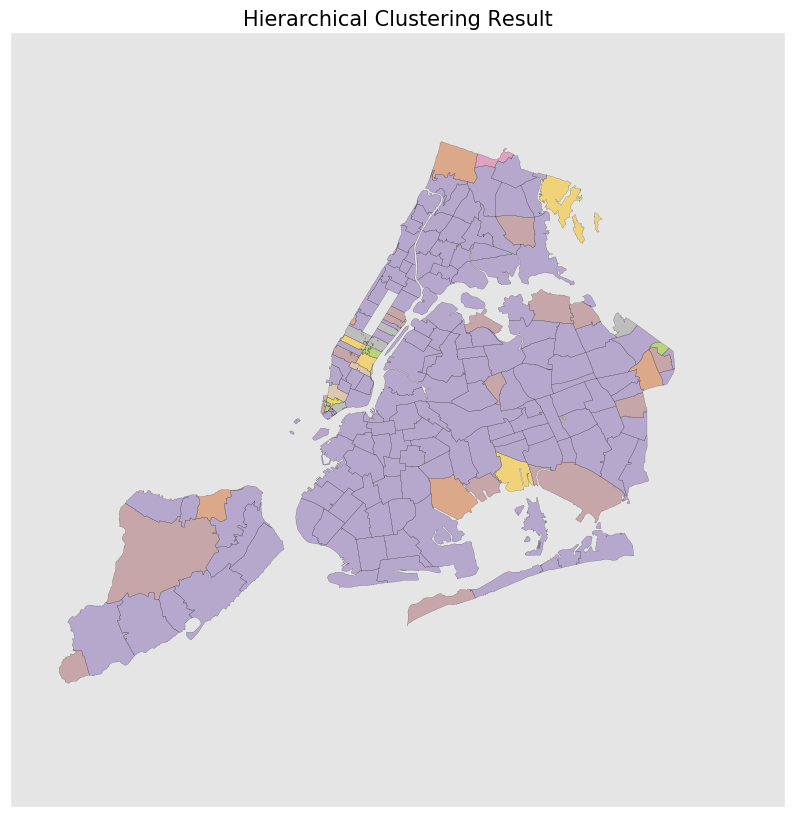

In [376]:
data_and_zip['agg'] = clusters
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
data_and_zip.plot(column='agg',cmap = 'Set2',alpha=0.8,linewidth=0.1,ax=ax)
plt.title("Hierarchical Clustering Result",fontsize = 15)
plt.show()

### Interpretation and Exploration
 
In this assignment I tried Kmeans clustering, Feature Agglomeration clustering and Hierarchical Clustering. The result of them shares similar pattern if we see the map. For each clustering methos there are some point we should pay attention, for the kmeans clustering, I used the silhouette method to find the number of cluster, which is very straight forward. The Hierarchical Clustering methos is new to me, it took me many time to fighre out how does it work, and I choose 'complete' attribute in this case.

From the map result we can find that the maps share major similarity, and the majority are similar, some special locations stand out, such as uptown Manhattan and downtown Manhattan are special, and they really similar to each other. And in all three maps the left upper of bronx seems very unique.